In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
from utils.ecb_rates import get_ecb_rates
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from utils.viz import bar, set_axis
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import torch
from utils.utils import get_delta, get_previous_values
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from collections import Counter

/home/onyxia/work/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Première Approche

De manière similaire a ce qui a été fait en cours, on peut récupérer les termes importants du texte à l'aide du TFIDF des mots.

In [3]:
ecb_rates = get_ecb_rates()
ecb_press = pd.read_csv('data/data_glob.csv', index_col="date", parse_dates=True)

In [4]:
ecb_rates = get_delta(ecb_rates, "Deposit_Level_Alt")
ecb_press["content"] = ecb_press["content"].fillna("Error")
ecb_press = ecb_press[ecb_press["content"]!="Error"]

In [4]:
def aggregate_articles_for_date(date, ecb_press, window_days=14):
    start_date = date - pd.Timedelta(days=window_days)
    mask = (ecb_press.index >= start_date) & (ecb_press.index <= date)
    articles_in_window = ecb_press.loc[mask, 'content']
    return " ".join(articles_in_window)

ecb_press_agg = []
for rate_date in ecb_rates.index:
    aggregated_content = aggregate_articles_for_date(rate_date, ecb_press, window_days=14)
    ecb_press_agg.append(aggregated_content)

ecb_press_agg_df = pd.DataFrame({
    'content': ecb_press_agg
}, index=ecb_rates.index)

vectorizer = TfidfVectorizer(
    stop_words="english",
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 3),
    token_pattern=r"\b[a-zA-Z]{3,}\b",
    max_features=1000
)

X_ = vectorizer.fit_transform(ecb_press_agg_df["content"].values)

X_df = pd.DataFrame(X_.toarray(), columns=vectorizer.get_feature_names_out(), index=ecb_press_agg_df.index)

dates_communes = X_df.index.intersection(ecb_rates.index)

X_aligned = X_df.loc[dates_communes]
y_aligned = ecb_rates.loc[dates_communes, 'dummy_Deposit_Level_Alt']

X = X_aligned
y = y_aligned

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
elastic_net_model.fit(X_train, y_train)

coef = elastic_net_model.coef_
feature_names = vectorizer.get_feature_names_out()

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef
})

coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)

print(coef_df.head(20))



                  feature  coefficient  abs_coefficient
999                yields          0.0              0.0
0                 ability          0.0              0.0
1                    able          0.0              0.0
2                  access          0.0              0.0
3               according          0.0              0.0
4                 account          0.0              0.0
5               accounted          0.0              0.0
6              accounting          0.0              0.0
960                upward          0.0              0.0
961                   use          0.0              0.0
962                  used          0.0              0.0
963                  user          0.0              0.0
964                 users          0.0              0.0
965                 using          0.0              0.0
966             valuation          0.0              0.0
967                 value          0.0              0.0
952             unchanged          0.0          

In [5]:
#TODO Aller un peu plus loin la jai pas mis en forme mais globalement on fance dans le mur en faisant ça

## Utilisation d'un modèle Pré entrainé BERT

On aimerait faire de la sentiment analysis mais soit en non supervisé, soit à l'aide du transfer learning car on ne possède clairement pas assez de données pour entraîner et tester un modèle de sentiment analysis.

In [5]:
model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis", num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

device = 0 if torch.cuda.is_available() else -1  # 0 pour utiliser CUDA, -1 pour utiliser le CPU

model.to(device)

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)



Device set to use cuda:0


Les textes sont plus longs que 512 "tokens" on doit donc faire quelques pre processing

In [7]:
def split_text_into_chunks(text, max_length=500):
    tokens = tokenizer.encode(text, truncation=False)

    chunks = [tokens[i:i+max_length] for i in range(0, len(tokens), max_length)]
    return chunks


def apply_bert_to_text(text, return_scores=False):
    chunks = split_text_into_chunks(text)
    results = []
    for chunk in chunks:

        decoded_text = tokenizer.decode(chunk)
        result = nlp(decoded_text)
        results.append(result)
    
    if return_scores:
        return results
    
    labels = [item[0]['label'] for item in results]

    return Counter(labels)

La plupart des textes sont très "neutres", généralement on obtient des trucs genre 'neutral': beaucoup, "positif":1 "negatif": 0

In [10]:
# TODO Extraire un compte de positive ou negative et regarder si on peut trouver des correlations avec 
# la variable d'outome, si non -> réstreindre les données, si toujours aucune correl -> suicide

In [8]:
from datasets import Dataset

In [9]:
dataset = Dataset.from_pandas(ecb_press)

def process_row(row):
    return apply_bert_to_text(row["content"])

dataset = dataset.map(lambda row: {"count": process_row(row)}, batched=False)


Map: 100%|██████████| 1536/1536 [11:28<00:00,  2.23 examples/s]


In [146]:
df_processed = dataset.to_pandas()
df = df_processed.copy()
df.index = ecb_press.index # dataset a suppr l'index donc on le remet
ecb_extanded = ecb_rates.copy()
ecb_rates["Date"] = ecb_rates.index.values

ecb_extanded["val_prev"] = ecb_rates["Date"].apply(lambda x: get_previous_values(x, 7, df, "count")) # On recup 
# previous articles (ici 7 jours avant)

In [147]:
def sum_keys(dict_list):
    totals = {'negative': 0, 'neutral': 0, 'positive': 0}
    for d in dict_list:
        for key in totals.keys():
            totals[key] += d.get(key, 0) or 0
    return totals

ecb_temp = ecb_extanded["val_prev"].apply(sum_keys).apply(pd.Series)

df_2 = pd.concat([ecb_extanded, ecb_temp], axis=1)  # On recupère pour chaque article le "count" de positive
# negative et neutral

In [148]:
def normalise(array):
    return (array-array.min())/(array.max()-array.min())

In [149]:
df_reduced = df_2.loc[ecb_press.iloc[[-1]].index[0]:] # On récupère que a partir
# des dates pour lesquelles on a au moins un article

In [150]:
df_reduced["positive"]

Date
2018-11-20     1.0
2018-11-21     1.0
2018-11-22     1.0
2018-11-23     1.0
2018-11-24     1.0
              ... 
2024-12-10     3.0
2024-12-11     2.0
2024-12-12    15.0
2024-12-13    15.0
2024-12-18    15.0
Name: positive, Length: 2217, dtype: float64

In [151]:
neutral = df_reduced["neutral"]

In [152]:
df_reduced["test_pos"] = df_reduced["positive"]/mean

/tmp/ipykernel_13984/2548861757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced["test_pos"] = df_reduced["positive"]/mean


In [153]:
df_reduced["test_neg"] = df_reduced["negative"]/mean

/tmp/ipykernel_13984/1205139154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced["test_neg"] = df_reduced["negative"]/mean


In [154]:
euro_stoxx_50 = yf.download('^STOXX50E',
                            start = df_reduced.index.min(),
                            end = df_reduced.index.max()
                            )['Close']

[*********************100%***********************]  1 of 1 completed


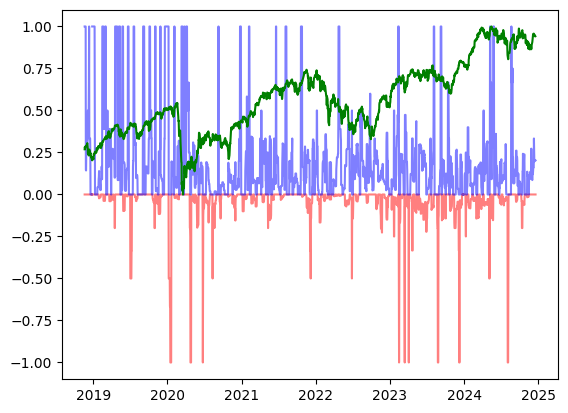

In [ ]:
plt.plot(-normalise(df_reduced["test_neg"]), c="r",alpha=0.5)
plt.plot(normalise(df_reduced["test_pos"]), c="b", alpha=0.5)
#plt.plot(normalise(df_reduced["positive"].to_numpy()))
plt.plot(normalise(euro_stoxx_50.iloc[:,0].fillna(0)), c="green")
#plt.plot(normalise(df_reduced["dummy_Deposit_Level_Alt"]), alpha=0.5)